In [1]:
import argparse
import os
import sys
import shutil
import random
import numpy as np
import time
import copy
import math
import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from transformers import GPT2TokenizerFast, BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
cs461dir = '/content/drive/My Drive/Colab Notebooks/CS461/'

file_paths = ['fake.test.txt', 'fake.train.txt', 'fake.valid.txt', 'real.test.txt', 'real.train.txt', 'real.valid.txt']
if any(not os.path.exists(filepath) for filepath in file_paths):
  !cp -r "{cs461dir}"* /content/
  print("Files imported")

model_path = "./model_weights"
os.makedirs(model_path, exist_ok=True)

def read_file(filename, tokenizer):
    bios = []
    curr_bio = []
    in_bio = False

    with open(filename, 'r') as f:
      for line in f:
        if '<start_bio>' in line:
          in_bio = True
          curr_bio = []
        elif '<end_bio>' in line:
          in_bio = False
          text = " ".join(curr_bio).strip()
          tokens = tokenizer.encode(text)
          bios.append(tokens)
        else:
          if in_bio:
            curr_bio.append(line)
    return bios

class FakeRealDataset(Dataset):
    def __init__(self, real_data, fake_data):
      #real is 0, fake is 1
      self.samples = []
      for seq in real_data:
          self.samples.append((seq, 0))
      for seq in fake_data:
          self.samples.append((seq, 1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def beautify_data(batch):
    token_lists, labels = zip(*batch)
    max_len = max(len(t) for t in token_lists)

    padded = []
    for tokens in token_lists:
        padded_seq = tokens + [0]*(max_len - len(tokens))
        padded.append(padded_seq)

    tokens_tensor = torch.tensor(padded, dtype=torch.long)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return tokens_tensor, labels_tensor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# FEED FORWARD NN - SIMPLE BASELINE TO COMPARE ENCODER TO
class SimpleFeedForward(nn.Module):
  def __init__(self, vocab_size=50257, embed_dim=512):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim)

    self.linear1 = nn.Linear(embed_dim, 32)
    self.relu1 = nn.LeakyReLU()
    self.linear2 = nn.Linear(32, 16)
    self.relu2 = nn.LeakyReLU()
    self.linear_out = nn.Linear(16, 2)

  def forward(self, input):
    embedding = self.embedding(input)
    avg_embedding = embedding.mean(dim=1)

    x = self.linear1(avg_embedding)
    x = self.relu1(x)
    x = self.linear2(x)
    x = self.relu2(x)
    x = self.linear_out(x)
    return x

def train(model, opt):
  optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr)
  criterion = nn.CrossEntropyLoss()
  model.to(opt.device)

  train_loss_plot = []
  valid_loss_plot = []

  for epoch in range(opt.epochs):
    model.train()
    correct, total = 0, 0
    total_loss = 0.0

    for ids, labels in opt.train:
      ids = ids.to(opt.device)
      labels = labels.to(opt.device)

      optimizer.zero_grad()
      pred = model(ids)
      loss = criterion(pred, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

      _, preds = torch.max(pred, dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

    train_acc = 100.0 * correct / total
    avg_loss = total_loss / len(opt.train)
    val_acc, val_loss = test_model(model, opt, "valid")

    train_loss_plot.append(avg_loss)
    valid_loss_plot.append(val_loss)

    print(f"Epoch [{epoch+1}/{opt.epochs}] "
              f"Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}% || "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}%")


  plt.plot(list(range(1, opt.epochs + 1)), train_loss_plot, label='Training Loss')
  plt.plot(list(range(1, opt.epochs + 1)), valid_loss_plot, label='Validation Loss')
  plt.xticks(list(range(2, opt.epochs + 1, 2)))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Loss')
  plt.show()

def test_model(model, opt, test_data="valid"):
  print("testing model...")
  model.to(opt.device)
  criterion = nn.CrossEntropyLoss()
  model.eval()

  dataset = opt.test if test_data == "test" else opt.valid
  correct, total = 0, 0
  total_loss = 0.0
  with torch.no_grad():
    for ids, labels in dataset:
      ids = ids.to(opt.device)
      labels = labels.to(opt.device)

      pred = model(ids)
      loss = criterion(pred, labels)
      total_loss += loss.item()

      _, preds = torch.max(pred, dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

    acc = 100.0 * correct / total
    avg_loss = total_loss / len(dataset)

    if test_data == "valid":
      return acc, avg_loss
    else:
      print(f"Test Accuracy: {acc:.4f},    Test Loss: {avg_loss:.4f}")
      return

Using device: cuda


Token indices sequence length is longer than the specified maximum sequence length for this model (1160 > 1024). Running this sequence through the model will result in indexing errors


testing model...
Epoch [1/20] Train Loss: 0.6930, Train Acc: 50.7347% || Val Loss: 0.6847, Val Acc: 50.7606%
testing model...
Epoch [2/20] Train Loss: 0.6806, Train Acc: 63.0809% || Val Loss: 0.6718, Val Acc: 74.0365%
testing model...
Epoch [3/20] Train Loss: 0.6686, Train Acc: 75.6091% || Val Loss: 0.6599, Val Acc: 85.3448%
testing model...
Epoch [4/20] Train Loss: 0.6548, Train Acc: 82.9440% || Val Loss: 0.6433, Val Acc: 87.5254%
testing model...
Epoch [5/20] Train Loss: 0.6377, Train Acc: 88.4012% || Val Loss: 0.6246, Val Acc: 92.0385%
testing model...
Epoch [6/20] Train Loss: 0.6173, Train Acc: 91.7295% || Val Loss: 0.6024, Val Acc: 92.3428%
testing model...
Epoch [7/20] Train Loss: 0.5904, Train Acc: 94.1346% || Val Loss: 0.5688, Val Acc: 94.0669%
testing model...
Epoch [8/20] Train Loss: 0.5566, Train Acc: 95.3341% || Val Loss: 0.5346, Val Acc: 94.0669%
testing model...
Epoch [9/20] Train Loss: 0.5183, Train Acc: 95.6481% || Val Loss: 0.4934, Val Acc: 95.9939%
testing model...
Ep

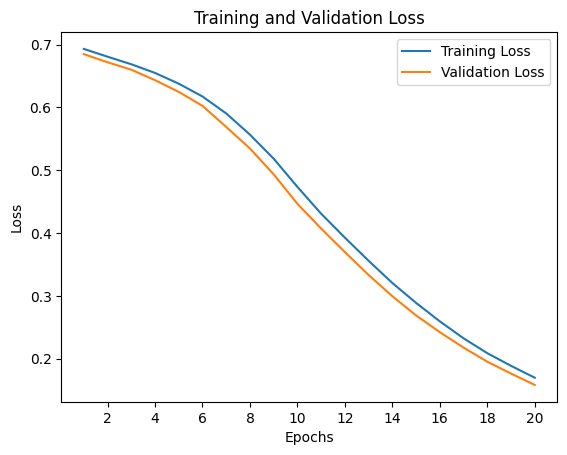

testing model...
Test Accuracy: 99.2871,    Test Loss: 0.1623


In [ ]:
# FFNN MAIN FUNCTION
def main():

  random.seed(10)

  parser = argparse.ArgumentParser()
  parser.add_argument('-no_cuda', action='store_true')
  parser.add_argument('-SGDR', action='store_true')
  parser.add_argument('-epochs', type=int, default=20)
  parser.add_argument('-batchsize', type=int, default=32)
  parser.add_argument('-printevery', type=int, default=100)
  parser.add_argument('-lr', type=float, default=0.00001)
  parser.add_argument('-savename', type=str, default="simple_model.pth")


  if "google.colab" in sys.modules:
      sys.argv = ["notebook"]

  opt = parser.parse_args()
  device = torch.device("cuda" if torch.cuda.is_available() and not opt.no_cuda else "cpu")
  opt.device = device

  print("Using device:", device)

  tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
  vocab_size = tokenizer.vocab_size

  real_train, fake_train = read_file('real.train.txt', tokenizer), read_file('fake.train.txt', tokenizer)
  real_valid, fake_valid = read_file('real.valid.txt', tokenizer), read_file('fake.valid.txt', tokenizer)
  real_test, fake_test = read_file('real.test.txt', tokenizer), read_file('fake.test.txt', tokenizer)

  train_dataset = FakeRealDataset(real_train, fake_train)
  valid_dataset = FakeRealDataset(real_valid, fake_valid)
  test_dataset  = FakeRealDataset(real_test,  fake_test)

  opt.train = DataLoader(train_dataset, batch_size=opt.batchsize, shuffle=True, collate_fn=beautify_data)
  opt.valid = DataLoader(valid_dataset, batch_size=opt.batchsize, shuffle=False, collate_fn=beautify_data)
  opt.test  = DataLoader(test_dataset, batch_size=opt.batchsize, shuffle=False, collate_fn=beautify_data)

  model = SimpleFeedForward(vocab_size=vocab_size, embed_dim=512)
  train(model, opt)

  # save a copy to drive
  #shutil.copy(os.path.join("./model_weights", opt.savename), cs461dir)
  os.makedirs("./model_weights", exist_ok=True)
  save_path = os.path.join("./model_weights", opt.savename)
  torch.save(model.state_dict(), save_path)
  shutil.copy(save_path, cs461dir)

  opt.loadname = "./model_weights/" + opt.savename
  test_model(model, opt, "test")

if __name__ == "__main__":
    main()

In [6]:
# BERT LM - ANOTHER BASELINE TO COMPARE ENCODER TO
def read_file_bert(filename, tokenizer):
    bios = []
    curr_bio = []
    in_bio = False

    with open(filename, 'r') as f:
        for line in f:
            if '<start_bio>' in line:
                in_bio = True
                curr_bio = []
            elif '<end_bio>' in line:
                in_bio = False
                text = " ".join(curr_bio).strip()
                encoding = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
                bios.append((encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0)))
            else:
                if in_bio:
                    curr_bio.append(line.strip())
    return bios

def beautify_data_bert(batch):
    input_ids, attention_masks, labels = zip(*[(data[0], data[1], label) for data, label in batch])
    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return input_ids, attention_masks, labels_tensor

def train_bert(model, opt):
    optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr, weight_decay=1e-3)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    model.to(opt.device)

    train_loss_plot = []
    valid_loss_plot = []

    for epoch in range(opt.epochs):
        model.train()
        correct, total = 0, 0
        total_loss = 0.0

        for input_ids, attention_masks, labels in opt.train:
            input_ids = input_ids.to(opt.device)
            attention_masks = attention_masks.to(opt.device)
            labels = labels.to(opt.device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_masks)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100.0 * correct / total
        avg_loss = total_loss / len(opt.train)
        val_acc, val_loss = test_model_bert(model, opt, "valid")

        train_loss_plot.append(avg_loss)
        valid_loss_plot.append(val_loss)

        print(f"Epoch [{epoch+1}/{opt.epochs}] "
              f"Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}% || "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}%")

    plt.plot(list(range(1, opt.epochs + 1)), train_loss_plot, label='Training Loss')
    plt.plot(list(range(1, opt.epochs + 1)), valid_loss_plot, label='Validation Loss')
    plt.xticks(list(range(2, opt.epochs + 1, 2)))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

def test_model_bert(model, opt, test_data="valid"):
    print("testing model...")
    model.to(opt.device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    model.eval()

    dataset = opt.test if test_data == "test" else opt.valid
    correct, total = 0, 0
    total_loss = 0.0
    with torch.no_grad():
        for input_ids, attention_masks, labels in dataset:
            input_ids = input_ids.to(opt.device)
            attention_masks = attention_masks.to(opt.device)
            labels = labels.to(opt.device)

            outputs = model(input_ids, attention_mask=attention_masks)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100.0 * correct / total
        avg_loss = total_loss / len(dataset)

        if test_data == "valid":
            return acc, avg_loss
        else:
            print(f"Test Accuracy: {acc:.4f}, Test Loss: {avg_loss:.4f}")

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


testing model...
Epoch [1/20] Train Loss: 0.4919, Train Acc: 78.5858% || Val Loss: 0.4409, Val Acc: 84.1278%
testing model...
Epoch [2/20] Train Loss: 0.3252, Train Acc: 92.1691% || Val Loss: 0.4326, Val Acc: 85.9026%
testing model...
Epoch [3/20] Train Loss: 0.2773, Train Acc: 95.3152% || Val Loss: 0.4174, Val Acc: 88.0325%
testing model...
Epoch [4/20] Train Loss: 0.2483, Train Acc: 97.1678% || Val Loss: 0.4792, Val Acc: 85.9533%
testing model...
Epoch [5/20] Train Loss: 0.2390, Train Acc: 97.6890% || Val Loss: 0.4439, Val Acc: 87.7282%
testing model...
Epoch [6/20] Train Loss: 0.2304, Train Acc: 98.1788% || Val Loss: 0.5126, Val Acc: 83.7221%
testing model...
Epoch [7/20] Train Loss: 0.2309, Train Acc: 98.1098% || Val Loss: 0.5126, Val Acc: 84.2799%
testing model...
Epoch [8/20] Train Loss: 0.2252, Train Acc: 98.5494% || Val Loss: 0.4073, Val Acc: 90.1623%
testing model...
Epoch [9/20] Train Loss: 0.2246, Train Acc: 98.5431% || Val Loss: 0.4490, Val Acc: 88.1846%
testing model...
Ep

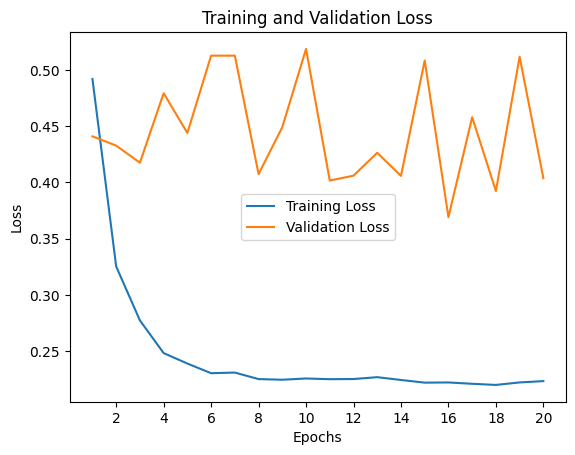

testing model...
Test Accuracy: 90.4468, Test Loss: 0.3922


In [7]:
# BERT MAIN FUNCTION
def main():
    random.seed(10)

    parser = argparse.ArgumentParser()
    parser.add_argument('-no_cuda', action='store_true')
    parser.add_argument('-epochs', type=int, default=20)
    parser.add_argument('-batchsize', type=int, default=16)
    parser.add_argument('-lr', type=float, default=0.00001)

    if "google.colab" in sys.modules:
        sys.argv = ["notebook"]

    opt = parser.parse_args()
    device = torch.device("cuda" if torch.cuda.is_available() and not opt.no_cuda else "cpu")
    opt.device = device

    print("Using device:", device)

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    real_train, fake_train = read_file_bert('real.train.txt', tokenizer), read_file_bert('fake.train.txt', tokenizer)
    real_valid, fake_valid = read_file_bert('real.valid.txt', tokenizer), read_file_bert('fake.valid.txt', tokenizer)
    real_test, fake_test = read_file_bert('real.test.txt', tokenizer), read_file_bert('fake.test.txt', tokenizer)

    train_dataset = FakeRealDataset(real_train, fake_train)
    valid_dataset = FakeRealDataset(real_valid, fake_valid)
    test_dataset = FakeRealDataset(real_test, fake_test)

    opt.train = DataLoader(train_dataset, batch_size=opt.batchsize, shuffle=True, collate_fn=beautify_data_bert)
    opt.valid = DataLoader(valid_dataset, batch_size=opt.batchsize, shuffle=False, collate_fn=beautify_data_bert)
    opt.test = DataLoader(test_dataset, batch_size=opt.batchsize, shuffle=False, collate_fn=beautify_data_bert)

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    model.config.hidden_dropout_prob = 0.5
    model.config.attention_probs_dropout_prob = 0.5
    model.to(opt.device)

    train_bert(model, opt)
    test_model_bert(model, opt, "test")

if __name__ == "__main__":
    main()